## Connecting to Federated Query Executed System

### Presto
``
conn = presto.Connection(host="presto", port=8080, user="demo")
cur = conn.cursor()
``
### Drill
``drill = PyDrill(host='drill', port=8047)``
### Spark
TODO
### Hive
TODO


In [1]:
%pip install pathlib
%pip install jinja2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import jinja2
import prestodb.dbapi as presto
from pydrill.client import PyDrill
import pandas as pd
import time

In [3]:
# configure sources
sources={
    "li_source":"pg1",
    "o_source":"pg2",
    "c_source":"pg3",
    "pa_source":"pg4",
    "s_source":"pg1",
    "ps_source":"pg2",
    "n_source":"pg3",
    "r_source":"pg4",
}

def get_sources_config(scale,**kwargs):
    """Returns a dict with tabels maped to sources"""
    mapped = {
        "lineitem":f"{kwargs['li_source']}.public.pg_{scale}_lineitem",
        "orders":f"{kwargs['o_source']}.public.pg_{scale}_orders",
        "customer":f"{kwargs['c_source']}.public.pg_{scale}_customer",
        "part":f"{kwargs['pa_source']}.public.pg_{scale}_part",
        "supplier":f"{kwargs['s_source']}.public.pg_{scale}_supplier",
        "partsupp":f"{kwargs['ps_source']}.public.pg_{scale}_partsupp",
        "nation":f"{kwargs['n_source']}.public.pg_{scale}_nation",
        "region":f"{kwargs['r_source']}.public.pg_{scale}_region"
    }
    return mapped


config = get_sources_config(scale="sf1",**sources)

In [4]:
def get_queries():
    return [q for q in Path("./queries").iterdir()]

def render_queries(sources_config,queries_path):
    """Returns a dict where the key is the tpch query name and the value is the rendered query"""
    result = {}
    for path in queries_path:
        key = path.name.split(".")[0]
        value = jinja2.Template(path.read_text()).render(**sources_config)
        result[key]=value
    return result

query_dict = render_queries(sources_config=config,queries_path=get_queries())

In [5]:
class Presto():
    def __init__(self,host="presto",port=8080,user="demo"):
        self.conn = presto.Connection(host="presto", port=8080, user="demo")
        self.cur = self.conn.cursor()
    
    def run_query(self,sql,show=False):
        self.cur.execute(sql)
        result = self.cur.fetchall()
        if show:
            return result

In [6]:
class Drill(PyDrill):
    def __init__(self,**kwargs):
        PyDrill.__init__(self, **kwargs)
        
    def run_query(self,sql,timeout=100000,show=False):
        if show:
            return self.query(sql,timeout=timeout).to_dataframe()
        return self.query(sql,timeout=timeout)

In [7]:
drill = Drill(host='drill', port=8047)

if not drill.is_active():
    raise ValueError('Please run Drill first')

presto = Presto()

## How Does Presto Execute a Query?

If you are curious about what Presto translate a SQL query to and what it will run, you can you `EXPLAIN`:

In [8]:
# conn = presto.Connection(host="presto", port=8080, user="demo")
# cur = conn.cursor()
# cur.execute('''
# SELECT
#     l_orderkey,
#     sum(l_extendedprice * (1 - l_discount)) as revenue,
#     o_orderdate,
#     o_shippriority
# FROM
#     pg2.public.pg_sf1_customer,
#     pg3.public.pg_sf1_orders,
#     pg3.public.pg_sf1_lineitem
# WHERE
#     c_mktsegment = 'BUILDING'
#     AND c_custkey = o_custkey
#     AND l_orderkey = o_orderkey
#     AND o_orderdate < date '1995-03-15'
#     AND l_shipdate > date '1995-03-15'
# GROUP BY
#     l_orderkey,
#     o_orderdate,
#     o_shippriority
# ORDER BY
#     revenue desc,
#     o_orderdate
# LIMIT 10
# ''')
# presto_res = cur.fetchall()

In [9]:
# presto_df = pd.DataFrame(presto_res,columns=["l_orderkey","revenue","o_orderdate","o_shippriority"])
# presto_df["l_orderkey"]=presto_df["l_orderkey"].astype(int)
# presto_df["o_shippriority"]=presto_df["o_shippriority"].astype(int)
# presto_df["revenue"]=presto_df["revenue"].astype(float)
# presto_df.dtypes

Execute `docker exec drill /bin/sh -c "./create_plugins.sh"` to add storage to drill. This should be done everytime you restart drill container, as there is no persistant storage where the config is saved. 

This can be improved by finding where the configuration are written ang mounting a volume there.

In [10]:
# drill_res = drill.query('''SELECT
#     l_orderkey,
#     sum(l_extendedprice * (1 - l_discount)) as revenue,
#     o_orderdate,
#     o_shippriority
# FROM
#     pg2.public.pg_sf1_customer,
#     pg3.public.pg_sf1_orders,
#     pg3.public.pg_sf1_lineitem
# WHERE
#     c_mktsegment = 'BUILDING'
#     AND c_custkey = o_custkey
#     AND l_orderkey = o_orderkey
#     AND o_orderdate < date '1995-03-15'
#     AND l_shipdate > date '1995-03-15'
# GROUP BY
#     l_orderkey,
#     o_orderdate,
#     o_shippriority
# ORDER BY
#     revenue desc,
#     o_orderdate
# LIMIT 10''', timeout=1000)

In [11]:
# drill_df = drill_res.to_dataframe()
# drill_df["l_orderkey"]=presto_df["l_orderkey"].astype(int)
# drill_df["o_shippriority"]=presto_df["o_shippriority"].astype(int)
# drill_df["revenue"]=presto_df["revenue"].astype(float)
# drill_df.dtypes

In [12]:
def are_equal(df1,df2):
    m = df1.merge(df2, how='outer', indicator=True)
    return len(m[m["_merge"]!="both"]) == 0

In [13]:
# are_equal(drill_df,presto_df)

# Benchmark

In [14]:
def benchmark(system,query,iterations=1):
    sum = 0
    count = 0
    for _ in range(iterations):
        count = count + 1
        start = time.time()
        system.run_query(query)
        end = time.time()
        sum = sum + (end - start)
    return sum/count

In [15]:
# q2, q9, q11 -> cannot run as ps_supplycost column by partsupp is not shown by presto
presto_benchmark_results=[]

presto_benchmark_results.append(benchmark(presto,query_dict["q1"],iterations=10))
presto_benchmark_results.append(benchmark(presto,query_dict["q3"],iterations=10))
presto_benchmark_results.append(benchmark(presto,query_dict["q4"],iterations=10))
presto_benchmark_results.append(benchmark(presto,query_dict["q5"],iterations=10))
presto_benchmark_results.append(benchmark(presto,query_dict["q7"],iterations=10))
print(presto_benchmark_results)

[23.55935666561127, 10.46391978263855, 15.526761364936828, 11.201081395149231, 11.805983877182006]


In [17]:
drill_benchmark_results=[]

drill_benchmark_results.append(benchmark(drill,query_dict["q1"],iterations=10))
drill_benchmark_results.append(benchmark(drill,query_dict["q3"],iterations=10))
drill_benchmark_results.append(benchmark(drill,query_dict["q4"],iterations=10))
drill_benchmark_results.append(benchmark(drill,query_dict["q5"],iterations=10))
drill_benchmark_results.append(benchmark(drill,query_dict["q7"],iterations=10))
print(drill_benchmark_results)

POST http://drill:8047/query.json [status:500 request:8.038s]


TransportError: TransportError(500, '{\n  "errorMessage" : "RESOURCE ERROR: There is not enough heap memory to run this query using the web interface. \\n\\nPlease try a query with fewer columns or with a filter or limit condition to limit the data returned. \\nYou can also try an ODBC/JDBC client. \\n\\n[Error Id: 5407aa4c-ad28-48ef-8a57-a709f0d7be45 ]"\n}')

In [19]:
drill_benchmark_results.append(benchmark(drill,query_dict["q3"],iterations=10))

In [23]:
drill_benchmark_results.append(benchmark(drill,query_dict["q4"],iterations=10))

In [33]:
drill = Drill(host='drill', port=8047)
# drill_benchmark_results.append(benchmark(drill,query_dict["q5"],iterations=10))
drill_benchmark_results.append(0)

In [34]:
drill_benchmark_results.append(benchmark(drill,query_dict["q7"],iterations=10))

In [37]:
drill_benchmark_results

[24.875804400444032,
 30.99094581604004,
 6.658303618431091,
 0,
 57.805634188652036]

In [38]:
presto_benchmark_results

[23.55935666561127,
 10.46391978263855,
 15.526761364936828,
 11.201081395149231,
 11.805983877182006]

In [39]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


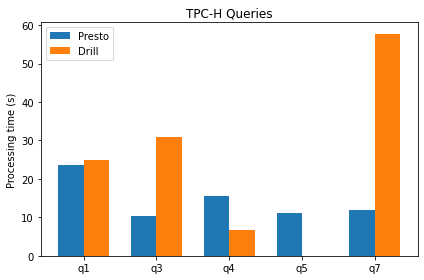

In [49]:
import matplotlib.pyplot as plt
import numpy as np
labels = ["q1","q3","q4","q5","q7"]
x = np.arange(len(labels))
width = 0.35 
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, presto_benchmark_results, width, label='Presto')
rects2 = ax.bar(x + width/2, drill_benchmark_results, width, label='Drill')

ax.set_ylabel('Processing time (s)')
ax.set_title('TPC-H Queries')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

## Create a Table in MySQL

Let's use the MySQL client to create the table. Then we will switch to Presto to manipulate the data:

In [ ]:
# import MySQLdb

# mysql = MySQLdb.connect(host="mysql", user="root", passwd="mysql")
# cur = mysql.cursor()
# cur.execute("CREATE DATABASE IF NOT EXISTS presto")
# cur.fetchall()
# cur.execute("""
#     CREATE TABLE IF NOT EXISTS presto.events (event LONGTEXT)
#     CHARSET utf8mb4 ENGINE=InnoDB
# """)
# cur.fetchall()
# cur.execute("DESC presto.events")
# for row in cur.fetchall():
#     print("{table}: [{props}]".format(
#         table=row[0],
#         props=', '.join(str(i) for i in row[1:])))

## Load Data in MySQL

Let's now load data from [GH Archive](http://www.gharchive.org/) into MySQL and MongoDB.
Each file from GH Archive contains lines of JSON structs that represent events from the public GitHub timeline, for example repository creation or code push.

Now that the table is create in MySQL, we can insert rows with Presto by using the existing `conn` object created above. You can open http://localhost:8080 to see the execution Presto queries.

In [ ]:
# import gzip
# import io
# import json
# import re
# import requests

# # Load events happening between 4-5pm.
# # Feel free to load more hours or more days.
# # We limit the dataset to one hour here to not overload
# # the machine that will run the queries as this tutorial
# # is expected to run on a laptop.
# # It is going to take some time. For the demo, i pre-loaded
# # the data with the mysql client to avoid the overhead of creating
# # Python objects.
# zdata = requests.get("https://data.gharchive.org/2015-04-28-16.json.gz")
# data = gzip.decompress(zdata.content)
# rows = []

# # load ``ROW_COUNT`` rows. Feel free to set a greater value if it
# # works well in your environment. Using a small value on purpose
# # to avoid loading data for a long time.
# ROW_COUNT = 1000
# cur = conn.cursor()
# for n, line in enumerate(io.BytesIO(data)):
#     row = line.strip().decode('utf8')
#     sql = "INSERT INTO mysql.presto.events (event) VALUES ('{}')".format(row.replace("'", "''"))
#     cur.execute(sql)
#     cur.fetchall()
#     if n == ROW_COUNT - 1:
#         break

In [ ]:
# cur = conn.cursor()
# cur.execute("SELECT json_extract(json_parse(event), '$.type') FROM mysql.presto.events TABLESAMPLE BERNOULLI (1) LIMIT 1")
# cur.fetchall()

In [ ]:
# cur = conn.cursor()
# cur.execute("""
#     SELECT ev_type, repo_name, count(*) FROM (
#       SELECT
#         TRY(json_extract_scalar(ev, '$.repo.name')) as repo_name,
#         TRY(json_extract_scalar(ev, '$.type')) as ev_type FROM (
#           SELECT try(json_parse(event)) as ev FROM mysql.presto.events))
#     WHERE repo_name is not null and ev_type = 'PushEvent'
#     GROUP BY ev_type, repo_name
#     ORDER BY 3 DESC
#     LIMIT 10
# """)
# rows = cur.fetchall()
# import pandas as pd
# from IPython.display import display

# print(rows)
# df = pd.DataFrame(sorted(rows, key=lambda x: x[2], reverse=True))
# display(df)

In [ ]:
# cur = conn.cursor()
# cur.execute("CREATE TABLE mongodb.events.all AS SELECT * FROM mysql.presto.events")
# cur.fetchall()